In [19]:
from keras.applications.vgg19 import VGG19
from keras.preprocessing import image
from keras.applications.vgg19 import preprocess_input
from keras.models import Model
import json
import cPickle as pk
import os
import numpy as np
import pandas as pd
from time import time
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
def load_everything():
    # load configuration
    with open('../config.json', 'rb') as f:
        config = json.load(f)

    mainImPath = config['image_dir']
    pDir = config['pickle_dir']

    bb = pk.load(open(pDir + 'pDogs-bounding-boxes-clean.pd.pk', 'rb'))
    bb.dropna(inplace=True)

    breeds = list(sorted(bb.breed.unique().tolist()))

    return breeds, bb, mainImPath

def create_model(output_layer='block4_pool'):
    base_model = VGG19(weights='imagenet')
    model = Model(input=base_model.input, output=base_model.get_layer(output_layer).output)
    return model

def extract_feats(img_path):
        try:
            img = image.load_img(img_path, target_size=(224, 224))
        except IOError:
            print 'couldn\'t load file'
            return None

        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)

        block4_pool_features = model.predict(x)
        return block4_pool_features

def extract_all_feats(timing=True):
    all_feats = None
    for b in breeds:
        print 'on breed:', b
        imDir = mainImPath + breeds[0] + '/'
        ims = os.listdir(imDir)
        for im in ims:
            start = time()
            print 'on image:', im
            b4 = extract_feats(imDir + im)
            if b4 is None:
                continue

            if all_feats is None:
                files = [im]
                all_feats = b4
            else:
                files.append(im)
                all_feats = np.c_[all_feats, all_feats]

            if timing:
                print 'took', time() - start, 'seconds'

    return files, all_feats

def test(timing=True):
    start = time()
    testImDir = mainImPath + breeds[0] + '/'
    testIms = os.listdir(testImDir)
    print 'extracting features for', breeds[0]
    print 'file:', testIms[0]
    b4 = extract_feats(testImDir + testIms[0])
    if timing:
        runtime = time() - start
        print 'took', runtime, 'seconds'

    return b4, runtime

In [6]:
breeds, bb, mainImPath = load_everything()

In [7]:
base_model = VGG19(weights='imagenet')

# Here's the layers we can use as intermediate outputs:

In [16]:
for i in base_model.get_config()['layers']:
    print i['name']

input_1
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool
flatten
fc1
fc2
predictions


In [15]:
base_model.get_config()['layers'][0]

{'class_name': 'InputLayer',
 'config': {'batch_input_shape': (None, 3, 224, 224),
  'input_dtype': 'float32',
  'name': 'input_1',
  'sparse': False},
 'inbound_nodes': [],
 'name': 'input_1'}

In [17]:
model = create_model() # creates VGG19 model with block4_pool_features out

In [18]:
testFeat, runtime = test()

extracting features for Affenpinscher
file: Affenpinscher3-2.jpeg
took 6.73015594482 seconds


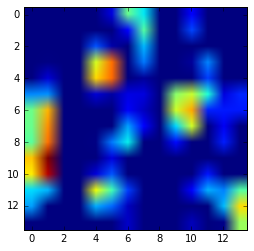

In [27]:
plt.imshow(testFeat[0][0])